In [23]:
import rasterio
from rasterio import warp
from rasterio.plot import show
from rasterio.mask import mask
# from rasterio.rio import clip
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from rasterio.windows import Window
from affine import Affine
from sklearn.decomposition import PCA
import numpy as np
import geopandas as gpd
import fiona

In [24]:
def trim_raster(data):
    """
    Parameters
    ----------
    data:
        A Rasterio-style numpy array (i.e., bands, rows, columns)
    
    Returns
    ------
    (1) the trimmed data...no nan values
    (2) the masked data array in Rasterio-style
    """
    
    bands, rows, cols = data.shape
    mask = np.isnan(data)
    mask = np.any(mask, axis=0)
    trimmed = data[:, ~mask].T
    
    return trimmed, np.invert(mask[np.newaxis, :])

In [25]:
def fill_trimmed_raster(data, mask, bands):
    """
    Parameters
    ----------
    data:
        A trimmed numpy array (i.e., the 'trimmed' output from trim_raster())
        
    mask:
        A mask of the original array (i.e., the 'mask' output from trim_raster())
    
    Returns
    ------
        The original data array in Rasterio-style (and nan's)
    """
    
    rows, cols = mask.shape
    output = np.empty((bands, rows, cols))
    output[:, :, :] = np.nan
    for b in range(bands):
        id = 0
        for r in range(rows):
            for c in range(cols):
                if mask[r, c]==True:
                    output[b, r, c] = data[id, b]
                    id+=1
    
    return output

## 0. Set input/output filenames

In [26]:
in_path = "./data/"
out_path = "./output/"

In [27]:
input_files = [in_path + i for i in ['t1011dc_nowtrS.img', 'toa8.img']]
output_files = [out_path + i for i in ['thermal_output.tif', 'toa_output.tif']]

## 1. Clip to city boundary and rasterize water pixels to nan's

In [28]:
shape_src = gpd.read_file("./data/dc_water_mask.geojson")

In [29]:
thermal_src = rasterio.open(input_files[0])
toa_src = rasterio.open(input_files[1])

In [30]:
thermal, thermal_transform = mask(thermal_src, shape_src.geometry, crop=True)
toa, toa_transform = mask(toa_src, shape_src.geometry, crop=True)
print(thermal.shape)
print(toa.shape)

(2, 692, 604)
(1, 1384, 1208)


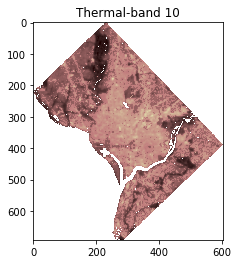

| 30.00, 0.00, 316297.50|
| 0.00,-30.00, 4318297.50|
| 0.00, 0.00, 1.00|


In [31]:
thermal[thermal==0] = np.nan
plt.title("Thermal-band 10")
plt.imshow(thermal[0], cmap='pink')
plt.show()
print(thermal_transform)

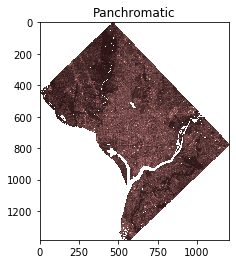

| 15.00, 0.00, 316297.50|
| 0.00,-15.00, 4318297.50|
| 0.00, 0.00, 1.00|


In [32]:
# toa = toa_src.read(1)
toa[toa==0] = np.nan
plt.title("Panchromatic")
plt.imshow(toa[0], cmap='pink')
plt.show()
print(toa_transform)

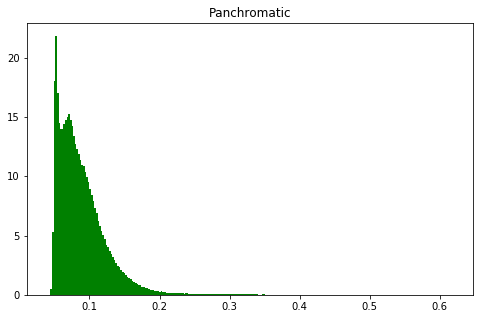

0.03974
0.6188800000000001


In [33]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
plt.title("Panchromatic")
n, bins, patches = axs.hist(toa.flatten(), 250, density=True, facecolor='g')
plt.show()
print(np.nanmin(toa))
print(np.nanmax(toa))

In [34]:
print(toa_src.meta)
print(thermal_src.meta)

{'driver': 'HFA', 'dtype': 'float64', 'nodata': None, 'width': 15661, 'height': 15901, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(15.0, 0.0, 220792.5,
       0.0, -15.0, 4426507.5)}
{'driver': 'HFA', 'dtype': 'float64', 'nodata': None, 'width': 662, 'height': 746, 'count': 2, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 315607.5,
       0.0, -30.0, 4319347.5)}


In [35]:
toa_meta = toa_src.meta
toa_meta.update(
    {"driver": "GTiff",
     "width": toa.shape[2],
     "height": toa.shape[1],
     "transform": toa_transform
    }     
)
print(toa_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1208, 'height': 1384, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(15.0, 0.0, 316297.5,
       0.0, -15.0, 4318297.5)}


In [36]:
thermal_meta = thermal_src.meta
thermal_meta.update(
    {"driver": "GTiff",
     "width": thermal.shape[2],
     "height": thermal.shape[1],
     "transform": thermal_transform
    }     
)
print(thermal_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 604, 'height': 692, 'count': 2, 'crs': CRS.from_epsg(32618), 'transform': Affine(30.0, 0.0, 316297.5,
       0.0, -30.0, 4318297.5)}


In [37]:
with rasterio.open(output_files[1], "w", **toa_meta) as dst:
    dst.write(toa[0], 1)

with rasterio.open(output_files[0], "w", **thermal_meta) as dst:
    dst.write(thermal[0], 1)
    dst.write(thermal[1], 2)

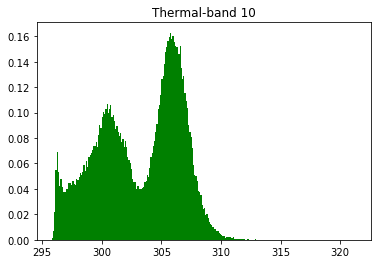

In [38]:
n, bins, patches = plt.hist(thermal[0].flatten(), 250, density=True, facecolor='g')
plt.title("Thermal-band 10")
plt.show()

## 2. Trim away the nan's

In [78]:
trimmed, mask = trim_raster(thermal)

In [42]:
print(trimmed)
print(trimmed.shape)

[[301.66171543 295.1754946 ]
 [301.57028668 295.10616365]
 [300.95206451 294.70040082]
 ...
 [296.27621507 290.99475298]
 [295.9857884  290.82514301]
 [295.97341356 290.85531231]]
(174853, 2)


In [46]:
print(mask)
print(mask[mask==True].shape)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
(174853,)


In [47]:
print(np.min(trimmed[:, 0]))
print(np.max(trimmed[:, 0]))

295.80312434709884
321.3335622312315


In [48]:
trimmed.shape

(174853, 2)

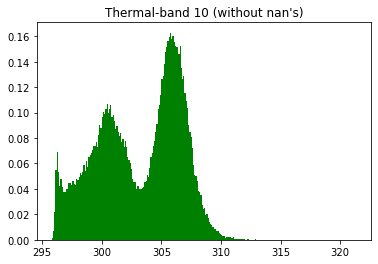

In [49]:
n, bins, patches = plt.hist(trimmed[:, 0], 250, density=True, facecolor='g')
# plt.xlim(285, 325)
plt.title("Thermal-band 10 (without nan's)")
plt.show()

In [50]:
print(np.min(trimmed[:, 1]))
print(np.max(trimmed[:, 1]))

290.82514301239155
314.3646572023841


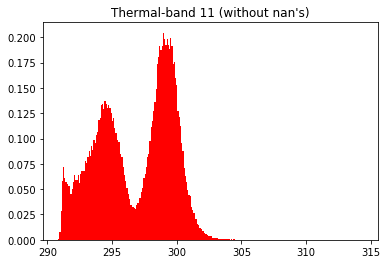

In [51]:
n, bins, patches = plt.hist(trimmed[:, 1], 250, density=True, facecolor='r')
plt.title("Thermal-band 11 (without nan's)")
plt.show()

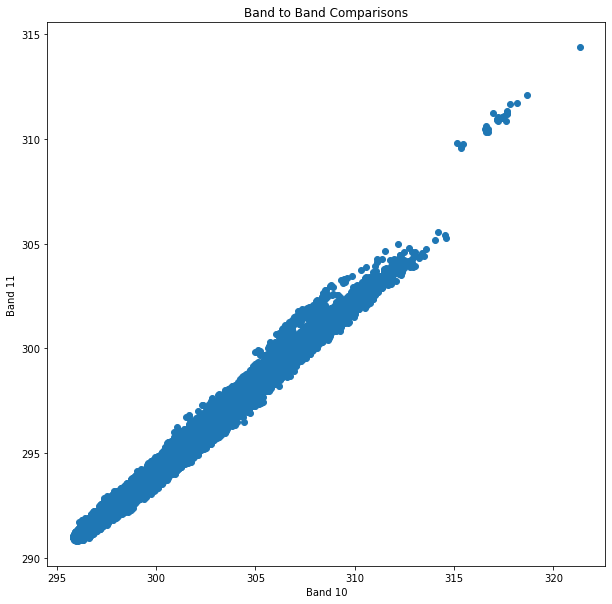

In [58]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.set_title("Band to Band Comparisons")
axs.set_xlabel("Band 10")
axs.set_ylabel("Band 11")
axs.scatter(trimmed[:, 0], trimmed[:, 1])

## 3. Perform Principal Components Analysis

In [59]:
pca = PCA(n_components=2)

In [60]:
pc = pca.fit_transform(trimmed)

In [61]:
print(pca.explained_variance_ratio_) 

[0.9983037 0.0016963]


In [62]:
print(pca.explained_variance_) 

[20.28795297  0.03447293]


In [63]:
print(pca.components_)

[[ 0.76968229  0.6384271 ]
 [-0.6384271   0.76968229]]


In [64]:
pc.shape

(174853, 2)

In [65]:
print(np.min(pc[:, 0]))
print(np.max(pc[:, 0]))

-9.358703885258848
25.231371883886066


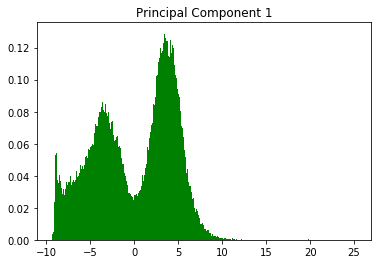

In [66]:
n, bins, patches = plt.hist(pc[:, 0], 500, density=True, facecolor='g')
plt.title("Principal Component 1")
plt.show()

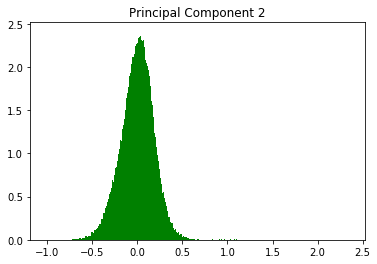

In [67]:
n, bins, patches = plt.hist(pc[:, 1], 500, density=True, facecolor='g')
plt.title("Principal Component 2")
plt.show()

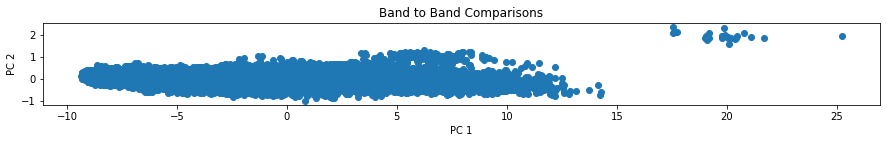

In [68]:
fig, axs = plt.subplots(1, 1, figsize=(15, 15))
axs.set_title("Band to Band Comparisons")
axs.set_xlabel("PC 1")
axs.set_ylabel("PC 2")
plt.gca().set_aspect('equal', adjustable='box')
axs.scatter(pc[:, 0], pc[:, 1])

## 4. Scale panchromatic band to the thermal range and perform inverse PCA mapping

In [92]:
toa2 = np.copy(toa)

pc_min = np.min(pc[:, 0])
pc_max = np.max(pc[:, 0])
pc_range = pc_max - pc_min
toa_min = np.nanmin(toa2)
# toa_max = np.nanmax(toa2)
toa_max = 0.25
toa_range = toa_max - toa_min
toa2[toa2 <= toa_min] = toa_min
toa2[toa2 >= toa_max] = toa_max
pan_stretched = (toa2 - toa_min) / toa_range * pc_range + pc_min
print(np.nanmin(pan_stretched))
print(np.nanmax(pan_stretched))
print(pan_stretched.shape)

-9.358703885258848
25.23137188388607
(1, 1384, 1208)


/home/nate/anaconda3/envs/vs-jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
/home/nate/anaconda3/envs/vs-jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


In [71]:
pan_stretched.shape

(1, 1384, 1208)

/home/nate/anaconda3/envs/vs-jupyter/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/nate/anaconda3/envs/vs-jupyter/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


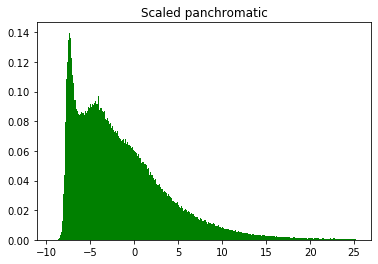

In [72]:
n, bins, patches = plt.hist(pan_stretched[0].flatten(), 500, density=True, facecolor='g')
plt.title("Scaled panchromatic")
plt.show()

In [73]:
t = pan_stretched.flatten().T
print(t.shape)

(1671872,)


In [74]:
print(pan_stretched[0].shape)
print(thermal[1].shape)
print(str(692 * 2) + ", " + str(604 * 2))

(1384, 1208)
(692, 604)
1384, 1208


In [75]:
thermal_upscaled = thermal[1].repeat(2, axis=0).repeat(2, axis=1)
print(thermal_upscaled.shape)

(1384, 1208)


In [76]:
p = pan_stretched.flatten().T
t = thermal_upscaled.flatten().T
X = np.array([p, t]).T
print(p.shape)
print(t.shape)
print(X.shape)

(1671872,)
(1671872,)
(1671872, 2)


In [86]:
hires = pca.inverse_transform(X)
print(hires.shape)

(1671872, 2)


In [89]:
h = hires[~np.isnan(hires)]
print(h.shape)

(1398824,)


In [84]:
trimmed, mask = trim_raster(thermal)

/home/nate/anaconda3/envs/vs-jupyter/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6735: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/nate/anaconda3/envs/vs-jupyter/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6736: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

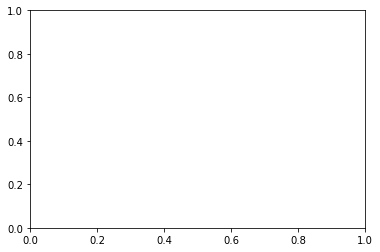

In [341]:
n, bins, patches = plt.hist(hires[0].flatten(), 500, density=True, facecolor='g')
plt.title("Pan-sharpened thermal-band 10")
plt.show()

## 5. Map back to band, row, column

In [28]:
pc = fill_trimmed_raster(trimmed, mask, thermal.shape[0])

In [29]:
pc[pc.shape[0] // 2, pc.shape[1] // 2, pc.shape[2] // 2]

300.06356432944744

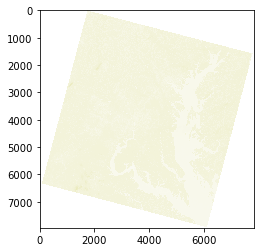

In [92]:
pyplot.imshow(pc[0], cmap='pink')
pyplot.show()

In [ ]:
a = thermal.flatten()
n, bins, patches = pyplot.hist(a, 250, density=True, facecolor='g')
pyplot.xlim(250, np.nanmax(a))
pyplot.show()

## Testing!!

In [267]:
r = c = 5
a = np.arange(r * c).reshape(r, c)

In [268]:
a

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [269]:
a.repeat(2, axis=0).repeat(2, axis=1)

array([[ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4],
       [ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4],
       [ 5,  5,  6,  6,  7,  7,  8,  8,  9,  9],
       [ 5,  5,  6,  6,  7,  7,  8,  8,  9,  9],
       [10, 10, 11, 11, 12, 12, 13, 13, 14, 14],
       [10, 10, 11, 11, 12, 12, 13, 13, 14, 14],
       [15, 15, 16, 16, 17, 17, 18, 18, 19, 19],
       [15, 15, 16, 16, 17, 17, 18, 18, 19, 19],
       [20, 20, 21, 21, 22, 22, 23, 23, 24, 24],
       [20, 20, 21, 21, 22, 22, 23, 23, 24, 24]])